### Phys 629, Fall 2023, University of Mississippi


# Lecture 18, Chapter 5: Bayesian Statistical Inference

Material in this lecture and notebook is based upon the Basic Stats portion of G. Richards' "Astrostatistics" class at Drexel University (PHYS 440/540, https://github.com/gtrichards/PHYS_440_540), the Introduction to Probability & Statistics portion of A. Connolly's & Ž. Ivezić's "Astrostatistics & Machine Learning" class at the University of Washington (ASTR 598, https://github.com/dirac-institute/uw-astr598-w18), J. Bovy's mini-course on "Statistics & Inference in Astrophysics" at the University of Toronto (http://astro.utoronto.ca/~bovy/teaching.html), and Stephen R. Taylor (https://github.com/VanderbiltAstronomy/astr_8070_s22). 

##### Reading:

- [Textbook](http://press.princeton.edu/titles/10159.html) Chapter 5.
- [David Hogg's "Fitting A Model To Data"](https://arxiv.org/abs/1008.4686)
- [Jake VanderPlas's workshop "Bayesian Astronomy"](https://github.com/jakevdp/BayesianAstronomy)
- [Jake VanderPlas's blog "Frequentism and Bayesianism: A Practical Introduction"](http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/)


##### Highly recommended supplemental background reading:

- [Jake VanderPlas: "Frequentism and Bayesianism: A Python-driven Primer"](https://arxiv.org/abs/1411.5018)
- [Hogg, Bovy and Lang: "Data analysis recipes: Fitting a model to data"](https://arxiv.org/abs/1008.4686)


##### For those who want to dive deep:

- [D. Sivia and J. Skilling: "Data Analysis: A Bayesian Tutorial"](https://www.amazon.com/Data-Analysis-Bayesian-Devinderjit-Sivia/dp/0198568320)
- [E.T. Jaynes: "Probability Theory: The Logic of Science"](http://bayes.wustl.edu/etj/prob/book.pdf)
- [E.T. Jaynes: "Confidence Intervals vs. Bayesian intervals"](http://bayes.wustl.edu/etj/articles/confidence.pdf)
- [This great explanation of confidence levels versus credible regions on Stackexchange](https://stats.stackexchange.com/questions/2272/whats-the-difference-between-a-confidence-interval-and-a-credible-interval/2287#2287)

***Exercises required for class participation are in <font color='red'>red</font>.***

#### Bayesian Evidence 

We can compute 

$$ E(M) \equiv p(D\,|\,M, I) = \int p(D\,|\,M, \theta, I) \, p(\theta\,|\,M, I) \, d\theta, $$

where $E(M)$ is called **the marginal likelihood for model $M$ (or "evidence" or "fully marginalized likelihood")** and it quantifies the probability that the  data $D$ would be observed if the model $M$ were the correct model. *Note: the symbol for Bayesian evidence is sometimes $\mathcal{Z}$; check for context!*

The evidence is a weighted average of the likelihood function with the prior for model parameters acting as the weighting function. 

#### How do we interpret the values of the odds ratio in practice?

**Jeffreys** proposed a scale for interpreting the odds ratio, where $O_{21} > 10$ represents *“strong”* evidence in favor of $M_2$ ($M_2$  is ten times more probable than $M_1$), and $O_{21} > 100$ is *“decisive”* evidence ($M_2$ is one hundred  times more probable than $M_1$). When $O_{21} < 3$, the evidence is *“not worth more than a bare mention.”*

The table below uses Bayes factors, which are numerically equivalent to odds ratios whenever we ascribe equal priors odds to our models.

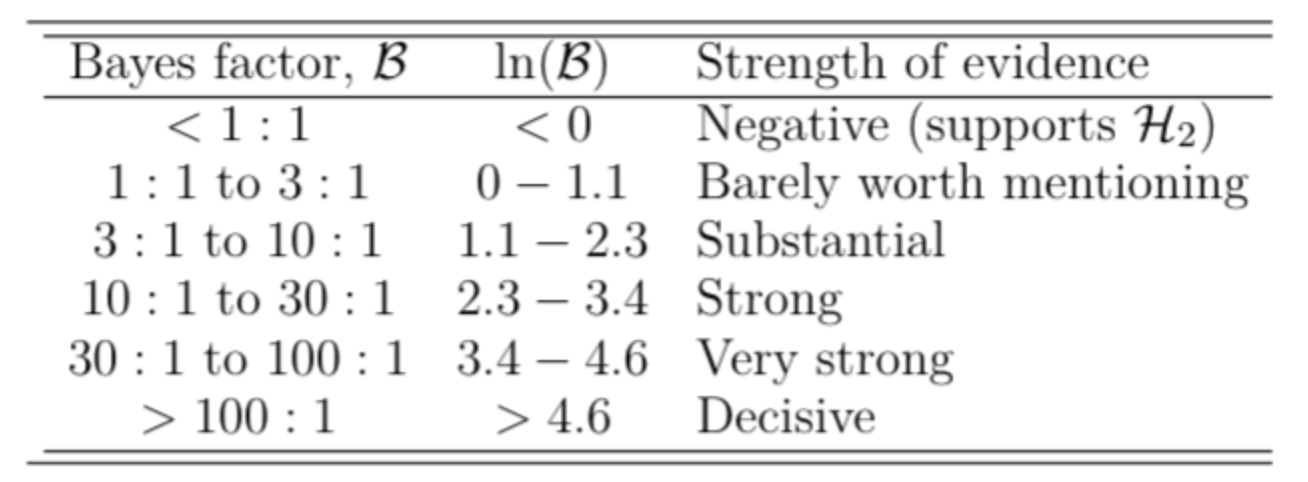

But note:
  * These are just **definitions of conventions**, i.e., a way to give a quantitative meaning to qualitative phrases.
  * The odds ratio **compares** the models, it doesn't tell us about the *absolute* goodness of fit: model A can be 100x better than model B, but still be pretty lousy.
  * Remember: "***GIGO***" ***= Garbage In, Garbage Out***. If we use our powerful statistics to rank a bunch of lousy models, that's our fault.

### Hypothesis Testing

In *hypothesis testing* we are essentially comparing a model, $M_1$, to its complement.  That is $p(M_1) + p(M_2) = 1$.  If we take $M_1$ to be the "null" (default) hypothesis (which is generally that, for example, a correlation does *not* exist), then we are asking whether or not the data reject the null hypothesis.

- In **classical hypothesis testing** we can ask whether or not a single model provides a good description of the data.  
- In **Bayesian hypothesis testing**, we need to have an alternative model to compare to.

### Example of Cauchy Versus Gaussian Model Comparison <a class="anchor" id="twoa"></a>

<font color='red'>Execute the following cell to draw a sample from a Cauchy distribution (remember, it has heavy tails!) and perform Bayesian Model Comparison for Cauchy and Gaussian models.</font> The Bayesian evidence is computed as a direct brute-force numerical integral over parameter space-- no MCMC methods are used here.

Results for first 10 points:
  L(M = Cauchy) = 2.23e-17 +/- 8.19e-18
  L(M = Gauss)  = 6.50e-22 +/- 5.10e-22
Bayesian odds ratio of Cauchy-versus-Gaussian Models = 3.43e+04 +/- 2.69e+04


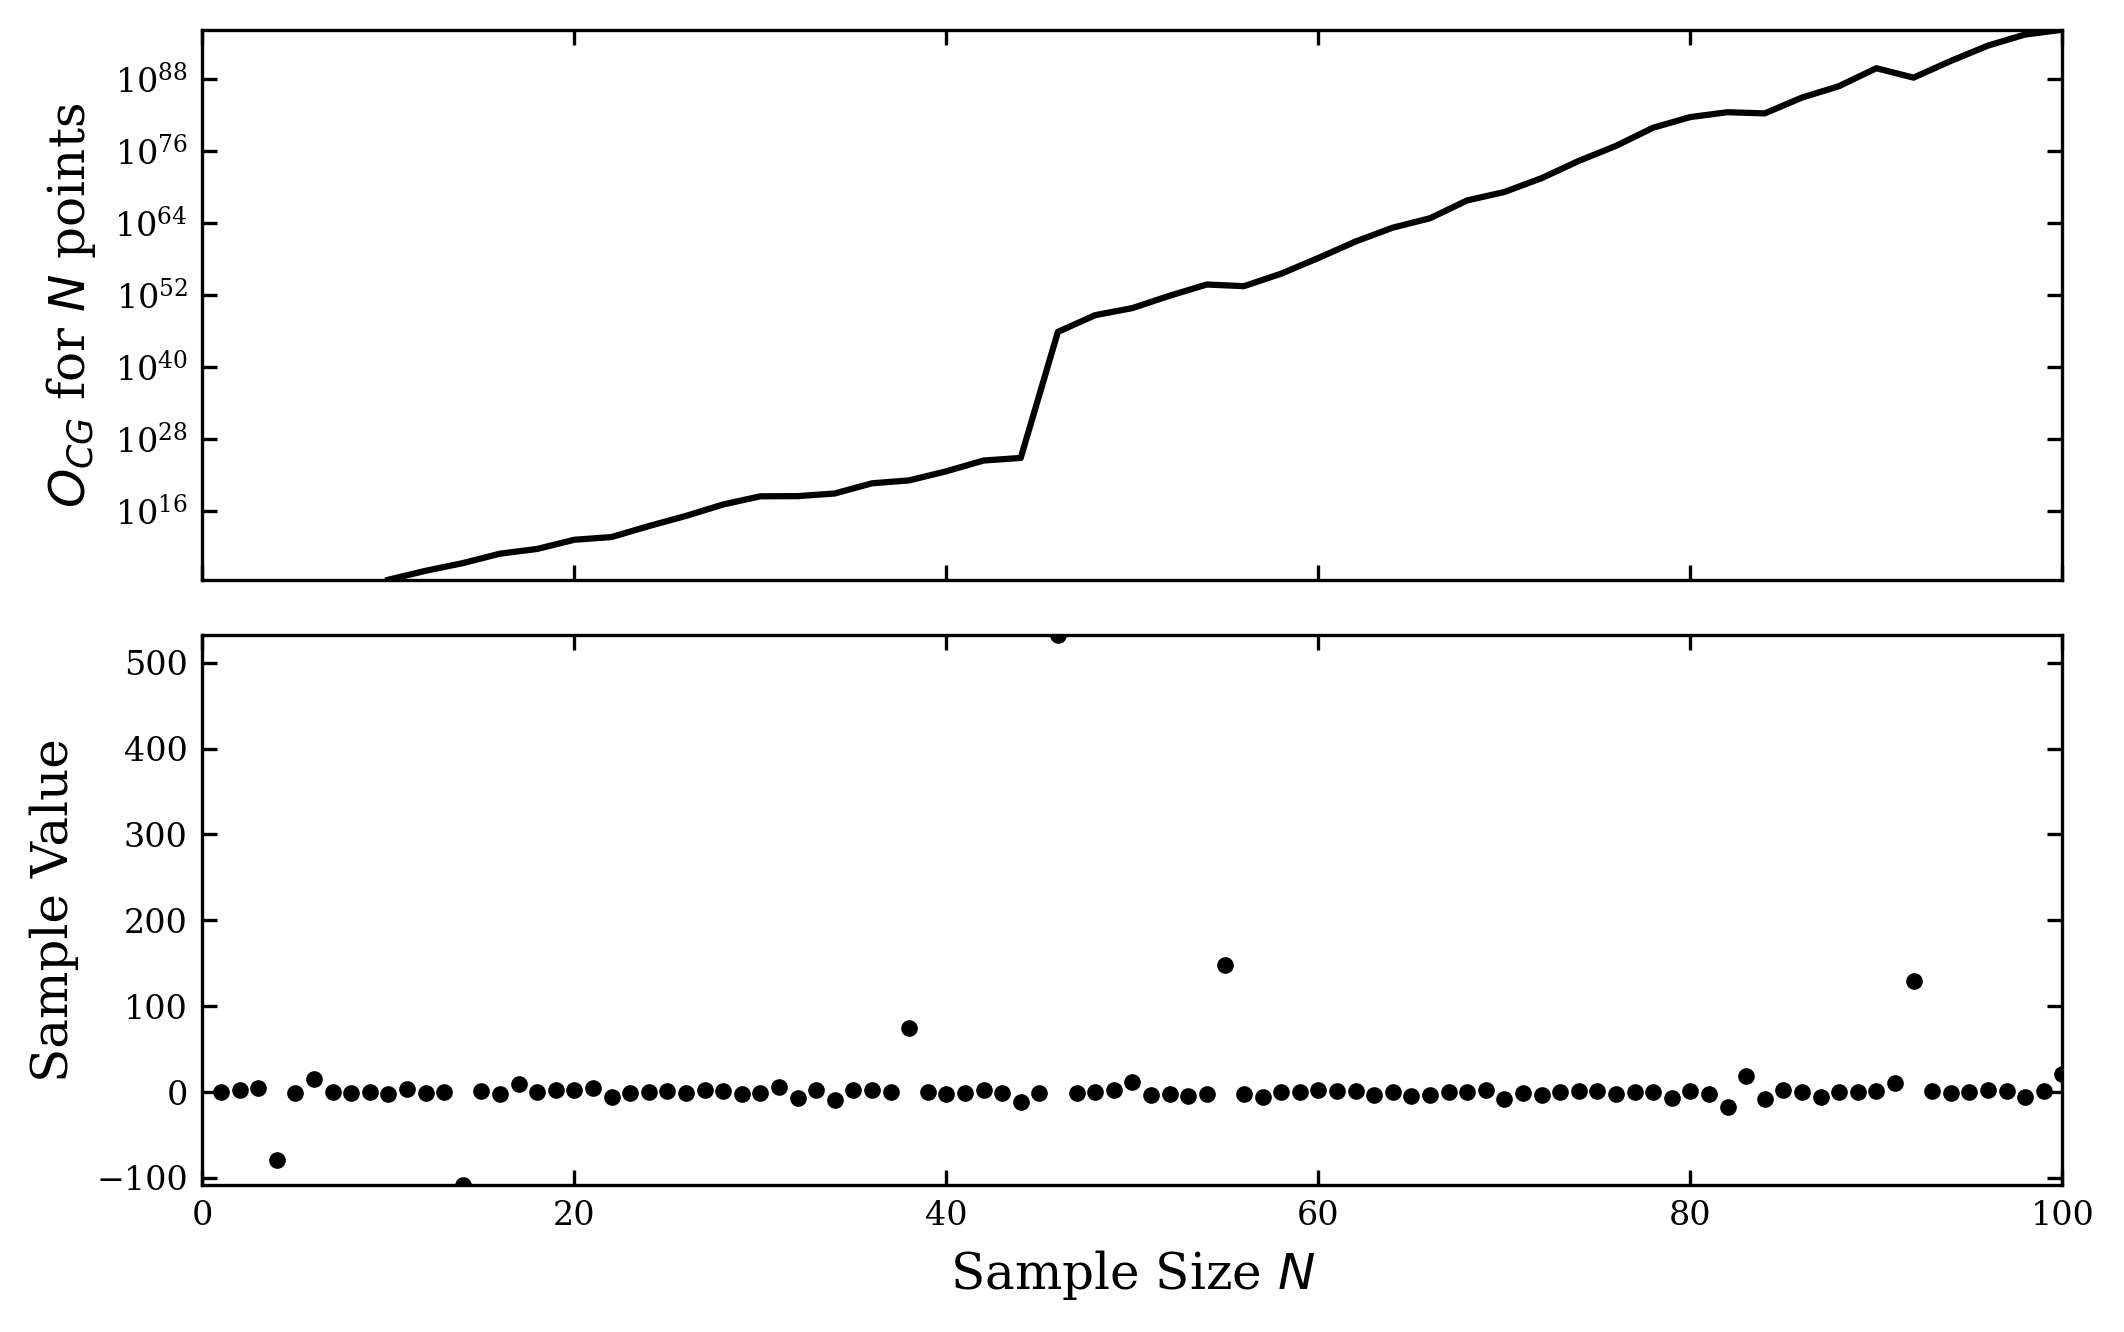

In [9]:


# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
from scipy.stats import cauchy, norm
from scipy import integrate
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 300  # To enhance the quality of rendered plots


#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)


def logL_cauchy(xi, gamma, mu,
                mu_min=-10, mu_max=10, sigma_min=0.01, sigma_max=100):
    """Equation 5.74: cauchy likelihood"""
    xi = np.asarray(xi)
    n = xi.size
    shape = np.broadcast(gamma, mu).shape

    xi = xi.reshape(xi.shape + tuple([1 for s in shape]))

    prior_normalization = - (np.log(mu_max - mu_min)
                             + np.log(np.log(sigma_max / sigma_min)))

    return (prior_normalization
            - n * np.log(np.pi)
            + (n - 1) * np.log(gamma)
            - np.sum(np.log(gamma ** 2 + (xi - mu) ** 2), 0))


def logL_gaussian(xi, sigma, mu,
                  mu_min=-10, mu_max=10, sigma_min=0.01, sigma_max=100):
    """Equation 5.57: gaussian likelihood"""
    xi = np.asarray(xi)
    n = xi.size
    shape = np.broadcast(sigma, mu).shape

    xi = xi.reshape(xi.shape + tuple([1 for s in shape]))

    prior_normalization = - (np.log(mu_max - mu_min)
                             + np.log(np.log(sigma_max / sigma_min)))

    return (prior_normalization
            - 0.5 * n * np.log(2 * np.pi)
            - (n + 1) * np.log(sigma)
            - np.sum(0.5 * ((xi - mu) / sigma) ** 2, 0))


def calculate_odds_ratio(xi, epsrel=1E-8, epsabs=1E-15):
    """
    Compute the odds ratio by perfoming a double integral
    over the likelihood space.
    """
    gauss_Ifunc = lambda mu, sigma: np.exp(logL_gaussian(xi, mu, sigma))
    cauchy_Ifunc = lambda mu, gamma: np.exp(logL_cauchy(xi, mu, gamma))

    I_gauss, err_gauss = integrate.dblquad(gauss_Ifunc, -np.inf, np.inf,
                                           lambda x: 0, lambda x: np.inf,
                                           epsabs=epsabs, epsrel=epsrel)
    I_cauchy, err_cauchy = integrate.dblquad(cauchy_Ifunc, -np.inf, np.inf,
                                             lambda x: 0, lambda x: np.inf,
                                             epsabs=epsabs, epsrel=epsrel)

    if I_gauss == 0:
        O_CG = np.inf
        err_O_CG = np.inf
    else:
        O_CG = I_cauchy / I_gauss
        err_O_CG = O_CG * np.sqrt((err_gauss / I_gauss) ** 2)

    return (I_gauss, err_gauss), (I_cauchy, err_cauchy), (O_CG, err_O_CG)


#------------------------------------------------------------
# Draw points from a Cauchy distribution
np.random.seed(14)
mu = 0
gamma = 2
xi = cauchy(mu, gamma).rvs(100)

#------------------------------------------------------------
# compute the odds ratio for the first 10 points
((I_gauss, err_gauss),
 (I_cauchy, err_cauchy),
 (O_CG, err_O_CG)) = calculate_odds_ratio(xi[:10])

print("Results for first 10 points:")
print("  L(M = Cauchy) = %.2e +/- %.2e" % (I_cauchy, err_cauchy))
print("  L(M = Gauss)  = %.2e +/- %.2e" % (I_gauss, err_gauss))
print("Bayesian odds ratio of Cauchy-versus-Gaussian Models = %.3g +/- %.3g" % (O_CG, err_O_CG))

#------------------------------------------------------------
# calculate the results as a function of number of points
Nrange = np.arange(10, 101, 2)
Odds = np.zeros(Nrange.shape)
for i, N in enumerate(Nrange):
    res = calculate_odds_ratio(xi[:N])
    Odds[i] = res[2][0]

#------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(8, 5))
fig.subplots_adjust(hspace=0.1)

ax1 = fig.add_subplot(211, yscale='log')
ax1.plot(Nrange, Odds, '-k')
ax1.set_ylabel(r'$O_{CG}$ for $N$ points', fontsize=12)
ax1.set_xlim(0, 100)
ax1.xaxis.set_major_formatter(plt.NullFormatter())
ax1.yaxis.set_major_locator(plt.LogLocator(base=10000.0))

ax2 = fig.add_subplot(212)
ax2.scatter(np.arange(1, len(xi) + 1), xi, lw=0, s=16, c='k')
ax2.set_xlim(0, 100)
ax2.set_xlabel(r'Sample Size $N$', fontsize=12)
ax2.set_ylabel('Sample Value', fontsize=12)

plt.show()



The odds ratio for the first 10 points is very close to unity ($O_{CG} = 1.45$) and is therefore inconclusive.
 
***Why do we get an inconclusive odds ratio?*** 
- With only 10 points, the probability of drawing at least one point far away from the mean, which would strongly argue against the Gaussian model, is fairly small. 
- As the number of data values is increased, the ability to discriminate between the models increases, too. 
- As the above figure shows, when we increase the size of the observed sample, the odds ratio quickly favors the  Cauchy over the Gaussian model.

### Example of Coin Flip Bayesian Model Comparison <a class="anchor" id="twob"></a>

Let's look at an example using coin flips. Let's assume we have $N$ draws and $k$ are "success" (say, heads). 

We will compare two hypotheses:

- **M1**: the coin has a known heads probability $b_\ast$ (say, a fair coin with $b_\ast=0.5$), with a prior given by a delta function, $\delta(b-b_\ast)$,
- **M2**: the heads probability $b$ is unknown, with a uniform prior in the range 0–1.

Basically in **M1** we know about the fairness of the coin. In **M2** we don't know anything about the fairness of the coin.

The model that we need (parametrized by the probability of success $b$, with $k$ successes) is the *binomial distribution*:

  $$    p(k\,|\,b, N) = \frac{N!}{k! \, (N-k)!} \, b^k \, (1-b)^{N-k} $$

For model **M2** the prior for $b$ is flat in the range 0-1 and the product of the data likelihood and prior is same as above. However, for model **M1** the prior is a  delta function $\delta(b-b_\ast)$ and we get for the product of the data likelihood and prior (which picks out $b=b_\ast$) 

$$    p(k\,|\,b_\ast, N, M1)\,p(b|M1, I) = \frac{N!}{k! \, (N-k)!} \, b_\ast^k \, (1-b_\ast)^{N-k}. $$

Consequently, the **odds ratio** is given by 

$$ O_{21} = \int_0^1 \left(\frac{b}{b_\ast}\right)^k \left(\frac{1-b}{1-b_\ast}\right)^{N-k} db, $$

as illustrated in the following figure. 

 
![Ivezic, Figure 5.1](http://www.astroml.org/_images/fig_odds_ratio_coin_1.png)

This figure (from the textbook) illustrates the behavior of $O_{21}$ as a function of $k$ for two different values of $N$ and for two different values of $b_\ast$: $b_\ast = 0.5$  (**M1**: the coin is fair) and $b_\ast = 0.1$ (**M1**: the coin is biased to tails). 

*The ability to distinguish  the two hypothesis **improves** with the sample size.*

For example:
- when $b_\ast = 0.5$ and $k/N = 0.1$ ($k=1$ on the left and $k=2$ on the right), the odds ratio in favor of **M2** increases from $\sim 9$ for $N=10$ to $\sim 263$ for $N=20$. 
- when k = $b_\ast N$, the odds ratio is $0.37$ for $N=10$ and 0.27 for $N=20$. 
- **the simpler model is favored by the data**, and the support strengthens with the sample size. 

**NOTE** 
- *$O_{21}= \sqrt{\pi/(2N)}$ when k = $b_\ast N$ and $b_\ast = 0.5$.* 
- To build strong evidence that a coin is fair, $O_{21} < 0.1$, it takes as many as $N > 157$ tosses. 
- With N = 10,000, the heads probability of a fair coin is measured with a precision of 1% and the corresponding odds ratio is $O_{21} \approx 1/80$.

***Frequentist Versus Bayesian***

In the **frequentist approach**, we ask whether we can reject the "null hypothesis" that our coin is fair. Specifically, we ask whether a given $k$ is a very unusual outcome (at some significance level $\alpha$, say $\alpha=0.05$) for a fair coin with $b_\ast = 0.5$ and with a given N. 

In the **Bayesian approach**, we offer an alternative hypothesis that the coin has an unknown heads probability. While this probability can be estimated from provided data ($b_0$), **we consider all the possible values** of $b_0$ when comparing the two proposed hypotheses. 

## Approximate Bayesian Model Comparison <a class="anchor" id="three"></a>

While the full *Odds Ratio* is the ultimate goal, it can be costly to compute. So we have some *approximate methods* that balance between ***goodness of fit*** and ***model complexity***. 

### Akaike information criterion (AIC) 

We've seen this before! 

$${\rm AIC} \equiv -2 \ln [L_0(M)] + 2k + \frac{2k(k+1)}{N-k-1}.$$

### Bayesian information criterion (BIC)

- The BIC is new to us. 
- It can be derived from the Bayesian odds ratio by assuming that the likelihood is Gaussian (see $\S$5.4.2 in textbook for details). 
- It's easier to compute than the odds ratio because it is based on the maximum value of the likelihood, $L_0(M)$, rather than on the integration of the likelihood over the full parameter space (i.e. evidence $E(M)$). 

For $N$ data points and a model with $k$ parameters,

$${\rm BIC} \equiv -2 \ln [L_0(M)] + k \ln N.$$ 

where 
- the 1st term is equal to the model's $\chi^2$ (under the assumption of normality; note that this is not $\chi^2$ per degree of freedom!) and 
- the 2nd term on the RHS penalizes complex models relative to simple ones.

When two models are compared, **the model with the smaller BIC/AIC value wins**. If the models are equally successful in describing the data (i.e., they have the same value of $L_0(M)$), then the model with fewer free parameters wins. 

Let's use BIC to choose the best polynomial from the earlier line fitting example. 
Starting with

$${\rm BIC} = \chi^2 + k \ln N,$$ 

with $N=20$ we have:

<pre>
     model     chi2    k   k*ln(N)   BIC   
     ------------------------------------
    linear    11.32    2    5.99    17.31   
  quadratic    9.46    3    8.99    18.45   
     cubic     8.99    4   11.98    20.97  
</pre>

Therefore, **the improvement in $\chi^2$ for the quadratic model**, relative to the linear model, **is not large enough to justify another free model parameter.**

**BUT NOTE!** 
- The BIC and AIC are approximations and might not be valid if the underlying assumptions are not met.
- Furthermore, unlike the odds ratio, both of them penalize unconstrained parameters. The odds ratio does not care about unconstrained parameters.
- In general, it is better to compute the odds ratio when computationally feasible. 